## **Descarga de Bases**

In [1]:
from google.colab import drive

# Montamos nuestra unidad drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Nos dirigimos a la carpeta con los inputs
# %cd /content/drive/My\ Drive/2021-1/TAC/TA
%cd /content/drive/My\ Drive/TA

/content/drive/.shortcut-targets-by-id/1E6FH8qATLyjIcq0TwQVxmCJ1SdpR4yZr/TA


###**Imports**

In [3]:
import os
from matplotlib import image
from shutil import copyfile
import cv2
import seaborn as sns
import random

import PIL
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [4]:
%tensorflow_version 2.x
from tensorflow.keras import backend as K
import tensorflow as tf

tf.random.set_seed(0)

### **Lectura de imágenes**

In [5]:
#!mkdir data
#!cd data && unzip BSDS300-images.zip

In [6]:
# %ls -l

In [7]:
# srcPath = '/content/drive/My Drive/2021-1/TAC/TA/data/BSDS300/images'
srcPath = 'data/BSDS300/images'

train_scan_paths = os.listdir(srcPath + '/train')
test_scan_paths = os.listdir(srcPath + '/test')

train_scan_paths = [(srcPath + '/train/' + x) for x in train_scan_paths]
test_scan_paths = [(srcPath + '/test/' + x) for x in test_scan_paths]


print("train scan with length of: {}".format(len(train_scan_paths)))
print("test scan with length of: {}".format(len(test_scan_paths)))

train scan with length of: 200
test scan with length of: 100


In [8]:
train_scan_paths[:5]

['data/BSDS300/images/train/365025.jpg',
 'data/BSDS300/images/train/20008.jpg',
 'data/BSDS300/images/train/232038.jpg',
 'data/BSDS300/images/train/188091.jpg',
 'data/BSDS300/images/train/286092.jpg']

In [9]:
test_scan_paths[:5]

['data/BSDS300/images/test/170057.jpg',
 'data/BSDS300/images/test/163085.jpg',
 'data/BSDS300/images/test/220075.jpg',
 'data/BSDS300/images/test/167062.jpg',
 'data/BSDS300/images/test/43074.jpg']

###**Preprocesamiento**

In [10]:
def normalize_scan(image):

  norm_image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

  return norm_image

def resize_scan(scan, desired_width, desired_height):
  
  scan = cv2.resize(scan, (desired_height, desired_width))

  return scan

def preprocess_scan(path, width, height):
  
  scan = cv2.imread(path)  
  resized_scan = resize_scan(scan, width, height)  
  normalized_resized_scan = normalize_scan(resized_scan)

  return normalized_resized_scan

def generate_img(image): 
  plt.axis("off")
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.show()
def generate_img_2(image): 
  img = plt.imshow(image)
  # img.set_cmap('hot')
  plt.axis('off')
  # plt.show()

In [11]:
width = 256
height = 256

In [12]:
train_scans = [preprocess_scan(path, width, height) for path in train_scan_paths]
test_scans = [preprocess_scan(path, width, height) for path in test_scan_paths]

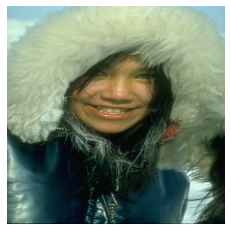

In [13]:
data = train_scans[0]

generate_img(data)
# plt.axis("off")
# plt.imshow(cv2.cvtColor(data, cv2.COLOR_BGR2RGB))
# plt.show()

In [14]:
def noisy(noise_typ,image):
  if noise_typ == "gauss":
    row,col,ch= image.shape
    mean = 0
    var = 0.01
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss
    return noisy
  elif noise_typ == "s&p":
    row,col,ch = image.shape
    s_vs_p = 0.5
    amount = 0.004
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
            for i in image.shape]
    out[coords] = 1

    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
            for i in image.shape]
    out[coords] = 0
    return out
  elif noise_typ == "poisson":
    vals = len(np.unique(image))
    vals = 2 ** np.ceil(np.log2(vals))
    noisy = np.random.poisson(image * vals) / float(vals)
    return noisy
  elif noise_typ =="speckle":
    row,col,ch = image.shape
    gauss = np.random.randn(row,col,ch)
    gauss = gauss.reshape(row,col,ch)        
    noisy = image + image * gauss
    return noisy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


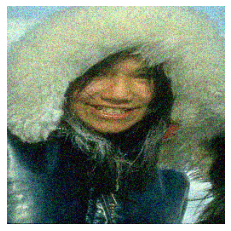

In [15]:
image = train_scans[0]
noisyimg = noisy('gauss', image)
generate_img(noisyimg.astype('float32'))

In [16]:
train_gaussian_noise_images = np.array([noisy('gauss', x) for x in train_scans])
test_gaussian_noise_images = np.array([noisy('gauss', x) for x in test_scans])

train_target_images = np.array(train_scans)
test_target_images = np.array(test_scans)

In [17]:
# Funcion de perdida - MSE
from tensorflow.keras.losses import MeanSquaredError

mse = tf.keras.losses.MeanSquaredError()
mse(train_gaussian_noise_images[0], train_scans[0]).numpy()

0.009957517

In [18]:
# Batch size
BATCH_SIZE = 10

# Train size
train_gaussian_noise_images.shape

(200, 256, 256, 3)

### ***Modelamiento***

In [66]:
from keras import Input, Model, Sequential
from keras import layers
from keras import backend as K
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomContrast, RandomRotation

K.clear_session()

In [67]:
data_augmentation = Sequential(
    [
     RandomFlip(mode="horizontal",seed=0),
     RandomContrast(0.1,seed=0)     
     ]
)

In [68]:
def Autoencoder():
  
  input_img = Input(shape=(256, 256, 3))  
  augmentation = data_augmentation(input_img)
  # ============================================================================
  # == ENCODER
  # ============================================================================

  conv_1_a = layers.Conv2D(48, (3, 3), padding='same', use_bias=False)(augmentation)
  l_relu_1_a = layers.LeakyReLU()(conv_1_a)
  conv_1_b = layers.Conv2D(48, (3, 3), padding='same', use_bias=False)(l_relu_1_a)
  l_relu_1_b = layers.LeakyReLU()(conv_1_b)
  maxpool_1 = layers.MaxPooling2D((2, 2), padding='same')(l_relu_1_b)
  #print(maxpool_1.shape)

  conv_2 = layers.Conv2D(48, (3, 3), padding='same', use_bias=False)(maxpool_1)
  l_relu_2 = layers.LeakyReLU()(conv_2)
  maxpool_2 = layers.MaxPooling2D((2, 2), padding='same')(l_relu_2)
  #print(maxpool_2.shape)

  conv_3 = layers.Conv2D(48, (3, 3), padding='same', use_bias=False)(maxpool_2)
  l_relu_3 = layers.LeakyReLU()(conv_3)
  maxpool_3 = layers.MaxPooling2D((2, 2), padding='same')(l_relu_3)
  #print(maxpool_3.shape)

  conv_4 = layers.Conv2D(48, (3, 3), padding='same', use_bias=False)(maxpool_3)
  l_relu_4 = layers.LeakyReLU()(conv_4)
  maxpool_4 = layers.MaxPooling2D((2, 2), padding='same')(l_relu_4)
  #print(maxpool_4.shape)

  conv_5_a = layers.Conv2D(48, (3, 3), padding='same', use_bias=False)(maxpool_4)
  l_relu_5_a = layers.LeakyReLU()(conv_5_a)
  maxpool_5 = layers.MaxPooling2D((2, 2), padding='same')(l_relu_5_a)
  #print(maxpool_5.shape)

  conv_5_b = layers.Conv2D(48, (3, 3), padding='same', use_bias=False)(maxpool_5)
  encoded = layers.LeakyReLU()(conv_5_b)

  # ============================================================================
  # == DECODER
  # ============================================================================

  upsamp_6 = layers.UpSampling2D((2, 2))(encoded)
  #print(upsamp_6.shape)
  concat_6 = tf.concat([upsamp_6, maxpool_4], axis=3)
  #print(concat_6.shape)
  conv_6_a = layers.Conv2D(96, (3, 3), padding='same', use_bias=False)(concat_6)
  l_relu_6_a = layers.LeakyReLU()(conv_6_a)
  conv_6_b = layers.Conv2D(96, (3, 3), padding='same', use_bias=False)(l_relu_6_a)
  l_relu_6_b = layers.LeakyReLU()(conv_6_b)
  
  upsamp_7 = layers.UpSampling2D((2, 2))(l_relu_6_b)
  #print(upsamp_7.shape)
  concat_7 = tf.concat([upsamp_7, maxpool_3], axis=3)
  #print(concat_7.shape)
  conv_7_a = layers.Conv2D(96, (3, 3), padding='same', use_bias=False)(concat_7)
  l_relu_7_a = layers.LeakyReLU()(conv_7_a)
  conv_7_b = layers.Conv2D(96, (3, 3), padding='same', use_bias=False)(l_relu_7_a)
  l_relu_7_b = layers.LeakyReLU()(conv_7_b)

  upsamp_8 = layers.UpSampling2D((2, 2))(l_relu_7_b)
  #print(upsamp_8.shape)
  concat_8 = tf.concat([upsamp_8, maxpool_2], axis=3)
  #print(concat_8.shape)
  conv_8_a = layers.Conv2D(96, (3, 3), padding='same', use_bias=False)(concat_8)
  l_relu_8_a = layers.LeakyReLU()(conv_8_a)
  conv_8_b = layers.Conv2D(96, (3, 3), padding='same', use_bias=False)(l_relu_8_a)
  l_relu_8_b = layers.LeakyReLU()(conv_8_b)

  upsamp_9 = layers.UpSampling2D((2, 2))(l_relu_8_b)
  #print(upsamp_9.shape)
  concat_9 = tf.concat([upsamp_9, maxpool_1], axis=3)
  #print(concat_9.shape)
  conv_9_a = layers.Conv2D(96, (3, 3), padding='same', use_bias=False)(concat_9)
  l_relu_9_a = layers.LeakyReLU()(conv_9_a)
  conv_9_b = layers.Conv2D(96, (3, 3), padding='same', use_bias=False)(l_relu_9_a)
  l_relu_9_b = layers.LeakyReLU()(conv_9_b)

  upsamp_10 = layers.UpSampling2D((2, 2))(l_relu_9_b)
  #print(upsamp_10.shape)
  concat_10 = tf.concat([upsamp_10, input_img], axis=3)
  #print(concat_10.shape)
  conv_10_a = layers.Conv2D(64, (3, 3), padding='same', use_bias=False)(concat_10)
  l_relu_10_a = layers.LeakyReLU()(conv_10_a)
  conv_10_b = layers.Conv2D(32, (3, 3), padding='same', use_bias=False)(l_relu_10_a)
  l_relu_10_b = layers.LeakyReLU()(conv_10_b)

  decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(l_relu_10_b)
  #print(decoded.shape)
  # decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(l_relu_7_b)

  return Model(input_img, decoded)

In [69]:
autoencoder = Autoencoder()

In [48]:
 %cd /content/drive/My Drive/TA_02_TAC

/content/drive/My Drive/TA_02_TAC


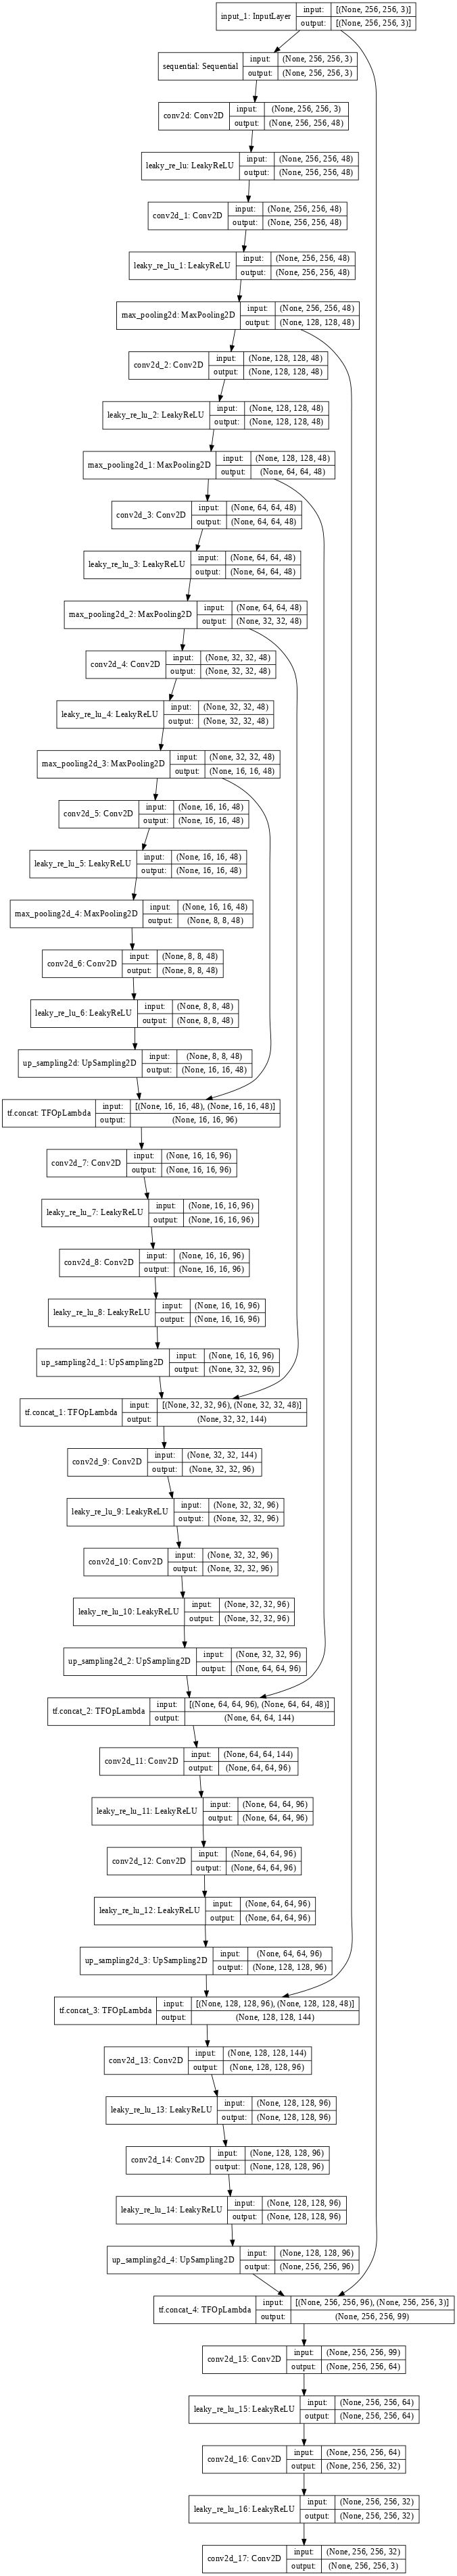

In [49]:
from tensorflow.keras.utils import plot_model
plot_model(autoencoder, show_shapes=True, dpi=64)

In [70]:
from tensorflow.keras.optimizers import Adam

# Definimos la funcion de optimizacion
autoencoder_optimizer = Adam(0.0001, beta_1=0.9)

### **Modelling**

In [71]:
autoencoder.compile(optimizer='adam', loss=MeanSquaredError(), metrics=['accuracy'])

In [73]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = "my_model/model_gauss_10"

monitor = "val_accuracy"

mode = "max"

model_checkpoint = ModelCheckpoint(checkpoint_path, monitor=monitor, verbose=1, save_best_only=True, save_weights_only=True, mode=mode)

In [86]:
# %cd /content/drive/MyDrive/TA_02_TAC/

In [74]:
EPOCHS = 40
history = autoencoder.fit(train_gaussian_noise_images, train_target_images,
                epochs=EPOCHS,
                shuffle=True,
                validation_data=(test_gaussian_noise_images, test_target_images), callbacks=[model_checkpoint])

Epoch 1/40
7/7 [==============================] - 8s 891ms/step - loss: 0.0668 - accuracy: 0.3937 - val_loss: 0.0649 - val_accuracy: 0.3895

Epoch 00001: val_accuracy improved from -inf to 0.38953, saving model to my_model/model_gauss_10_no_bias_01_adam_with_target_augmentation
Epoch 2/40
7/7 [==============================] - 5s 751ms/step - loss: 0.0582 - accuracy: 0.3891 - val_loss: 0.0435 - val_accuracy: 0.6283

Epoch 00002: val_accuracy improved from 0.38953 to 0.62827, saving model to my_model/model_gauss_10_no_bias_01_adam_with_target_augmentation
Epoch 3/40
7/7 [==============================] - 5s 754ms/step - loss: 0.0373 - accuracy: 0.5704 - val_loss: 0.0166 - val_accuracy: 0.5940

Epoch 00003: val_accuracy did not improve from 0.62827
Epoch 4/40
7/7 [==============================] - 5s 759ms/step - loss: 0.0283 - accuracy: 0.5916 - val_loss: 0.0211 - val_accuracy: 0.6149

Epoch 00004: val_accuracy did not improve from 0.62827
Epoch 5/40
7/7 [==============================]

### **Resultados**

In [55]:
def show_results(log):
  val_loss = log.history['val_loss']
  val_acc = log.history['val_accuracy']
      
  fig, axes = plt.subplots(1, 2, figsize=(14,4))
  ax1, ax2 = axes
  ax1.plot(log.history['loss'], label='train')
  ax1.plot(val_loss, label='test')
  ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
  ax2.plot(log.history['accuracy'], label='train')
  ax2.plot(val_acc, label='test')
  ax2.set_xlabel('epoch'); ax2.set_ylabel('accuracy')
  for ax in axes: ax.legend()

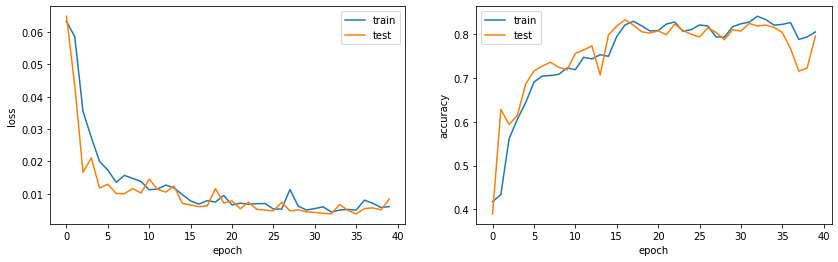

In [75]:
show_results(history)

### **Testing**

In [76]:
def generate_images(model, test_input, tar):
  prediction = model.predict(test_input.reshape(-1,256,256,3))
  plt.figure(figsize=(15, 15))

  display_list = [test_input.astype('float32'), tar.astype('float32'), prediction.reshape(256,256,3)]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])

    plt.axis("off")
    plt.imshow(cv2.cvtColor(display_list[i], cv2.COLOR_BGR2RGB))
    # img = plt.imshow(tf.cast((display_list[i] * 255),np.uint8))
    # # img.set_cmap('hot')
    # plt.axis('off')
    # print("OK 3")
    # plt.imshow(display_list[i])
    # plt.axis('off')

  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


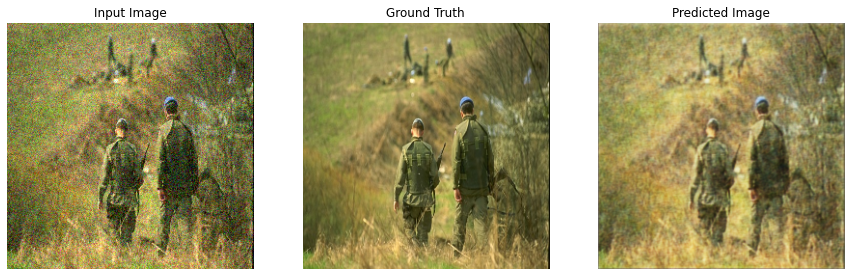

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


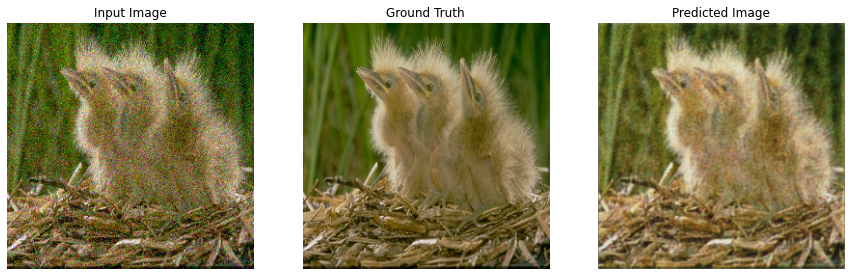

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


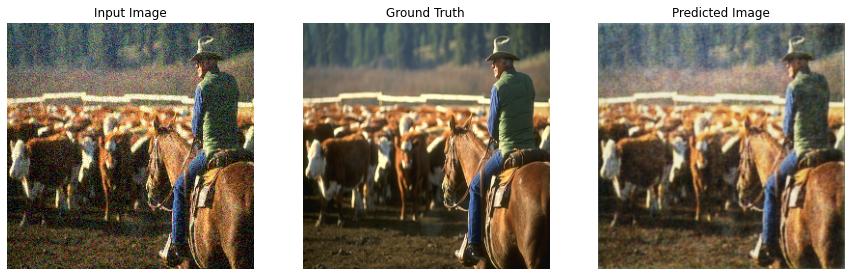

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


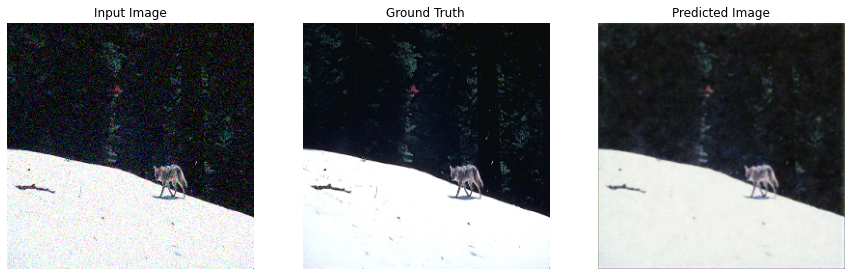

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


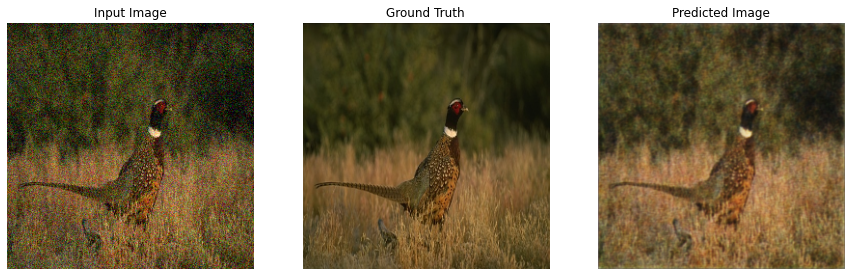

In [77]:
## Visualizamos algunas prediccinoes
for inp, tar in zip(test_gaussian_noise_images[:5], test_target_images[:5]):
  generate_images(autoencoder, inp, tar)

In [59]:
from math import log10, sqrt

def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

def plot_comparison(input_image, target_image, prediction):
    plt.figure(figsize=(15, 15))

    display_list = [input_image.astype('float32'), target_image.astype('float32'), prediction.astype('float32')]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      plt.axis("off")
      plt.imshow(cv2.cvtColor(display_list[i], cv2.COLOR_BGR2RGB))
    plt.show()

In [60]:
# Realizamos predicciones a las imagenes de testing y obtenemos el PSNR
list_test_predictions = []
list_PSNR = []
for inp, tar in zip(test_gaussian_noise_images, test_target_images):
    prediction = autoencoder.predict(inp.reshape(-1,256,256,3))
    prediction = prediction.reshape(256,256,3)
    list_test_predictions.append(prediction)
    list_PSNR.append(PSNR(tar, prediction))

In [78]:
np.array([100 - x for x in list_PSNR]).mean()

28.746880619551106

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


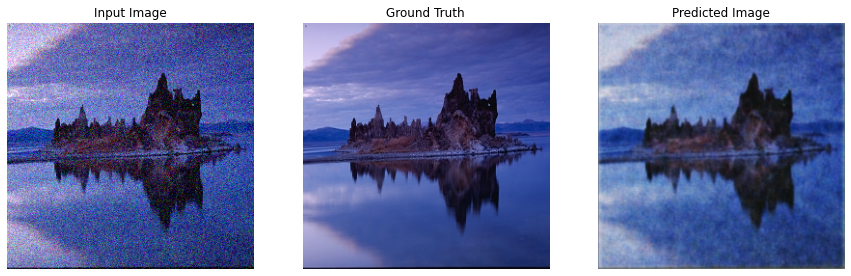

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


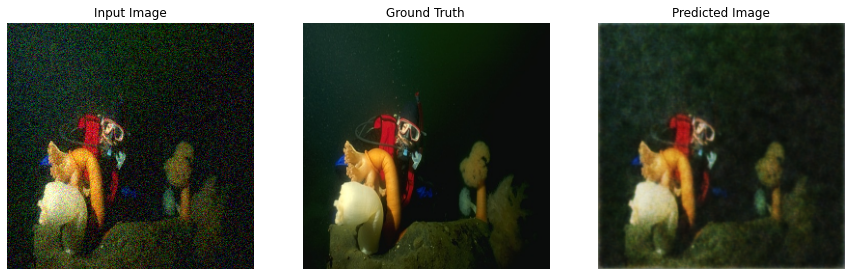

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


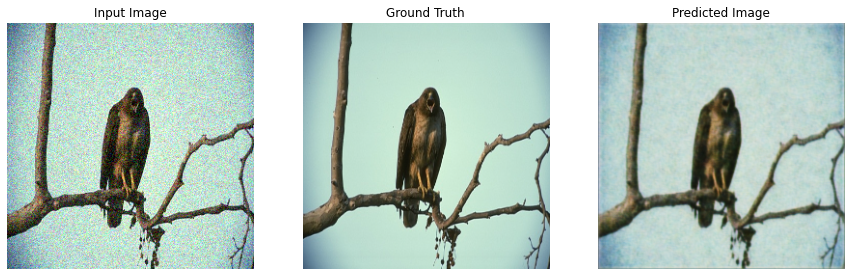

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


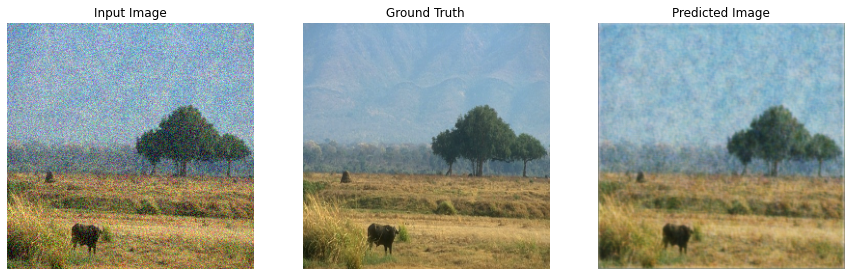

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


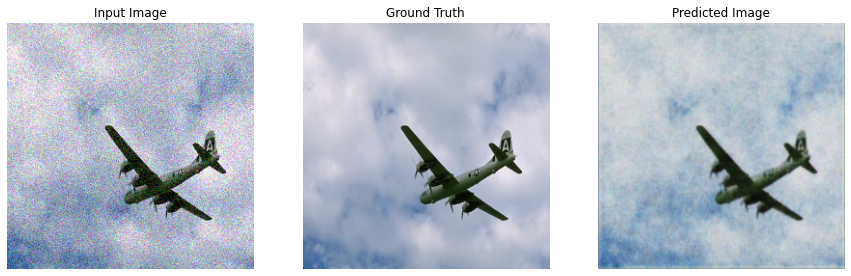

In [63]:
# TOP 5 RESULTADOS
for index in np.array(list_PSNR).argsort()[-5:]:
  plot_comparison(test_gaussian_noise_images[index], test_target_images[index],list_test_predictions[index])  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


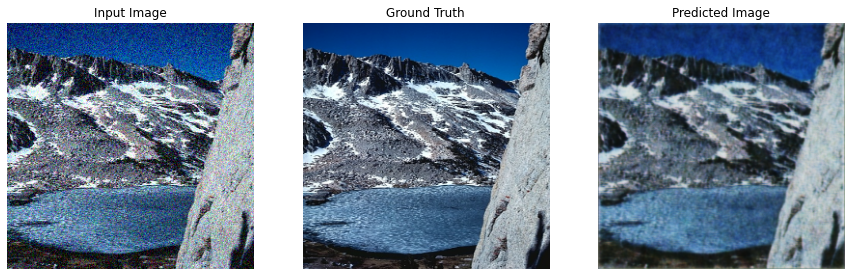

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


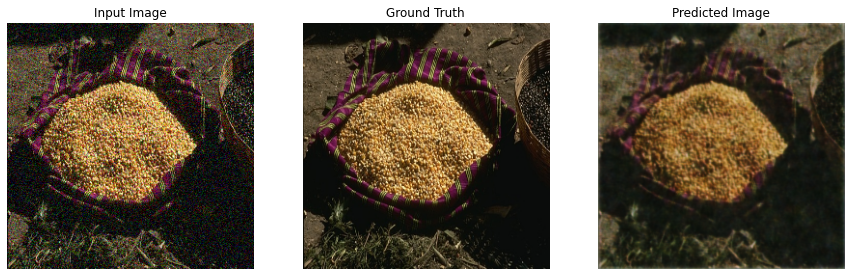

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


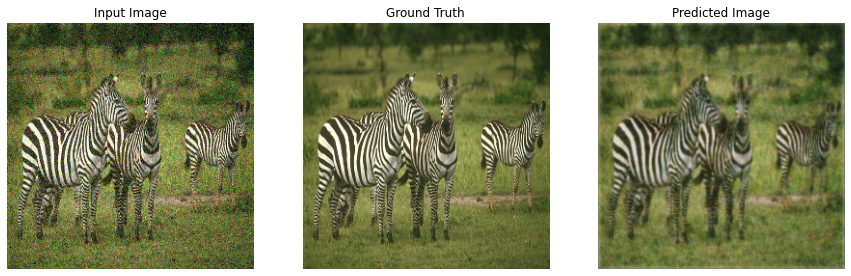

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


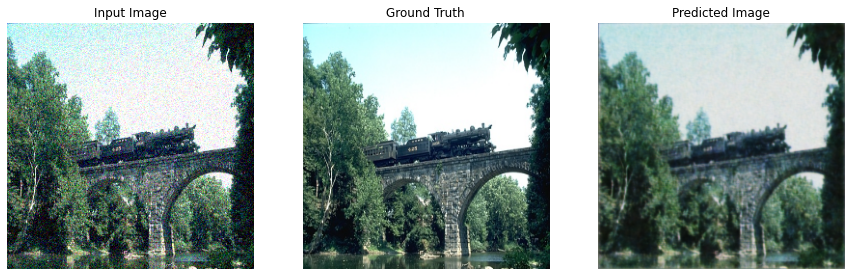

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


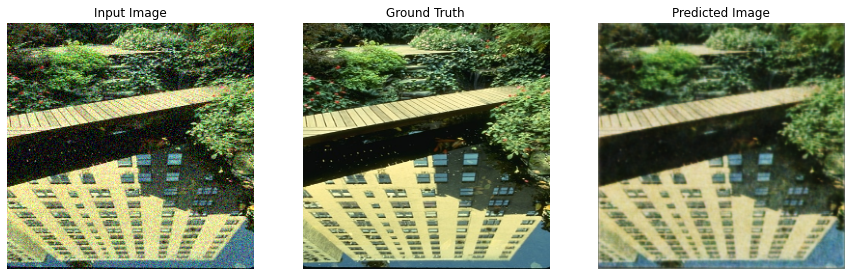

In [65]:
# BOTTOM 5 RESULTADOS
for index in np.array(list_PSNR).argsort()[:5]:
  plot_comparison(test_gaussian_noise_images[index], test_target_images[index],list_test_predictions[index])  

### **Training** [OLD]

In [ ]:
# checkpoint_dir = './training_checkpoints'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# checkpoint = tf.train.Checkpoint(generator_optimizer=autoencoder_optimizer,
#                                  autoencoder=autoencoder)

In [ ]:
# from datetime import datetime
# import time
# import os

# if not os.path.isdir('logs'):
#   os.mkdir('logs')

# log_dir="logs/"

# summary_writer = tf.summary.create_file_writer(
#   log_dir + "fit/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
# @tf.function
# def train_step(input_image, target, epoch):
#   with tf.GradientTape() as autoencoder_tape:
#     autoencoder_output = autoencoder(input_image, training=True)

#     mse_loss = mse(autoencoder_output, target)

#   autoencoder_gradients = autoencoder_tape.gradient(mse_loss,
#                                           autoencoder.trainable_variables)
#   autoencoder_optimizer.apply_gradients(zip(autoencoder_gradients,
#                                           autoencoder.trainable_variables))

#   with summary_writer.as_default():
#     tf.summary.scalar('autoencoder_mse_loss', mse_loss, step=epoch)

In [ ]:
# def fit(train_ds, epochs):
#   for epoch in range(epochs):
#     start = time.time()

#     # display.clear_output(wait=True)

#     # for example_input, example_target in test_ds.take(1):
#     #   generate_images(generator, example_input, example_target)
#     # print("Epoch: ", epoch)

#     # Training step
#     for n, (input_image, target) in train_ds.enumerate():
#       print('.', end='')
#       if (n+1) % 100 == 0:
#         print()
#       train_step(input_image, target, epoch)
#     print()

#     # Saving (checkpointing) the model every 20 epochs
#     if (epoch + 1) % 20 == 0:
#       checkpoint.save(file_prefix=checkpoint_prefix)

#     print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
#                                                         time.time()-start))
#   checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
# train_tuple = list(zip(train_target_images, train_target_images))

In [ ]:
# from tensorflow.data import Dataset

# ds_train_images = Dataset.from_tensor_slices(train_gaussian_noise_images)
# ds_target_images = Dataset.from_tensor_slices(train_target_images)

# train_dataset = Dataset.zip((ds_train_images,ds_target_images))
# train_dataset = train_dataset.batch(BATCH_SIZE)

In [ ]:
# tf.config.run_functions_eagerly(True)

In [ ]:
# fit(train_dataset, EPOCHS)